###  Exploratory data analysis of the mouse brain somatosensory cortex

In this notebook we will load and explore some statistics of the SeqFish+ Mouse Somatosensory Cortex dataset from [Eng *et al.* (2019)](https://www.nature.com/articles/s41586-019-1049-y). The tidy data we'll be using can be obtained [in this repo](https://github.com/RubD/spatial-datasets).

In [51]:
import pandas as pd 
import numpy as np
from numba import njit
import seaborn as sns 
import matplotlib.pyplot as plt
sns.set_style('white')

%config InlineBackend.figure_format = 'retina'

### Load gene counts dataset

First-off, we want to load the gene count matrix. In this experiment, the Cai Lab was able to profile 10,000 genes using their SeqFish+ method. We will be using a subset from the somatosensory cortex. The specific regions can be seen in the image below:

In [75]:
from IPython.display import Image

In [77]:
cortex_url = 'https://github.com/RubD/spatial-datasets/blob/master/data/\
2019_seqfish_plus_SScortex/raw_data/cortex_svz_location_fields.png?raw=true'

Image(url= cortex_url , format = 'png')

We can directly load the dataset from github using pandas. 

In [6]:
url_counts = 'https://raw.githubusercontent.com/RubD/spatial-datasets/\
master/data/2019_seqfish_plus_SScortex/count_matrix/cortex_svz_expression.txt'

counts = pd.read_csv(url_counts, index_col = 0, sep = ' ')

In [72]:
# Take a look 
counts.head()

,cell_1,cell_2,cell_3,cell_4,cell_5,cell_6,cell_7,cell_8,cell_9,cell_10,...,cell_904,cell_905,cell_906,cell_907,cell_908,cell_909,cell_910,cell_911,cell_912,cell_913
1700022a21rik,3,1,0,0,0,1,1,0,0,0,...,1,0,2,0,0,0,0,0,0,0
1700025g04rik,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4933401b06rik,2,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5830417i10rik,0,0,1,0,1,0,1,1,0,0,...,0,0,0,1,0,2,0,0,0,0
9330102e08rik,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
counts.shape

(10000, 913)

We can see that the dataset has genes in its rows and cells as columns. A good first step to get a sense of the data is to plot the distributions for genes across cells (to check if there are genes with few counts) and for cells across gens (to check that if there are cells with too few or too many counts). 

Let's start with the genes. 

In [15]:
dist_genes = counts.sum(axis = 1)

In [19]:
dist_genes.head()

1700022a21rik    241
1700025g04rik    199
4933401b06rik    178
5830417i10rik    341
9330102e08rik    212
dtype: int64

Text(0, 0.5, 'log(counts)')

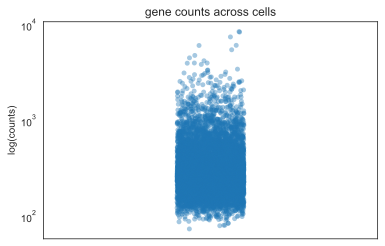

In [63]:
sns.stripplot(dist_genes.values, edgecolor = 'white', orient = 'v', alpha = 0.4)
plt.yscale('log')
plt.title('gene counts across cells')
plt.ylabel('log(counts)')

We can see that most of the genes have well between $10^2$  and $10^3$ counts across all cells with few outliers having a lot of counts. This is what we would like to see, so the dataset looks very high quality. We can go ahead and do the same for cells. 

In [23]:
dist_cells = counts.sum(axis = 0)

In [24]:
dist_cells.head()

cell_1    11173
cell_2     4587
cell_3     6310
cell_4     2167
cell_5     4998
dtype: int64

Text(0, 0.5, 'log(counts)')

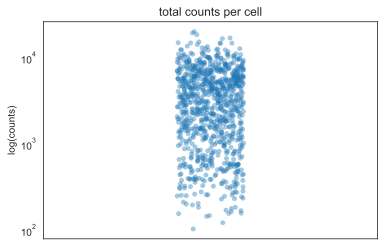

In [53]:
sns.stripplot(dist_cells, orient = 'v', alpha = 0.4)
plt.yscale('log')
plt.title('total counts per cell')
plt.ylabel('log(counts)')

Great, We can see that cells are in a good range between $10^2$ and $10^4$ counts per cell. As you could imagine, the cells with a lot of counts could bias our downstream analysis, so we have to normalize our data to take that into account. 

### Normalization 

Our normalization method is based on the normalization reported on the PopAlign ([Chen et al.](https://www.biorxiv.org/content/10.1101/421354v4)) which is also the standard in the field. For each gene $g_i$, the new expression value $g'_i$ will be given by 

$$
g'_i = \text{log} \left( \alpha \frac{g_i}{\sum_i^n g_i} + 1 \right)
$$

where the sum goes across all genes in each cell. The parameter $\alpha$ is set to $10^4$ as a convention of the field. The intuition is that we want to scale the counts to represent the proportion of the counts by a given gene. Then we bring those frequencies to a scale that can be more interpretable to the scale of transcripts per cell. Afterwards we represent this quantity in a log scale in order to not overflow the importance of highly abundant genes. We will be leveraging numpy broadcasting to make operations across the dimensions of the counts matrix. 

In [64]:
# Divide by sum across all genes per cell
counts_norm_by_cell = counts / dist_cells

In [65]:
# Make sure each cell sums to one 
counts_norm_by_cell.sum(axis = 0).head()

cell_1    1.0
cell_2    1.0
cell_3    1.0
cell_4    1.0
cell_5    1.0
dtype: float64

Now we can go ahead and apply our normalization. 

In [69]:
alpha = 1e4
norm_counts = np.log10(alpha*counts_norm_by_cell + 1)

Text(0, 0.5, 'cells')

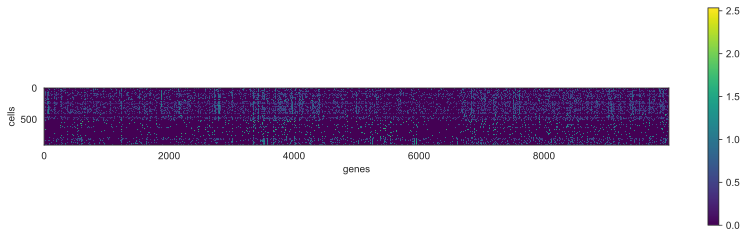

In [70]:
# Take a look 
plt.figure(figsize = (14, 4))
plt.imshow(norm_counts.T, cmap = 'viridis')
plt.colorbar()
plt.xlabel('genes')
plt.ylabel('cells')

At this point, a good next step would be to get to filter highly variable genes and then get the cell types but we'll stop here for now. 

### Load the coordinates dataset. 

In [74]:
coords_url = 'https://raw.githubusercontent.com/RubD/spatial-datasets/master/\
data/2019_seqfish_plus_SScortex/cell_locations/cortex_svz_centroids_rotated.csv'

coords = pd.read_csv(coords_url)
coords.head()

,Field of View,Cell ID,X,Y
0,0,1,1632.02,1305.70
1,0,2,1589.47,669.51
2,0,3,1539.89,1185.90
3,0,4,1513.94,710.24
4,0,5,1477.85,763.87


In [78]:
coords.shape

(913, 4)

In [80]:
coords['Field of View'].value_counts()

5    281
0    118
6    109
1    108
3    106
4    101
2     90
Name: Field of View, dtype: int64

Text(0, 0.5, 'Y axis')

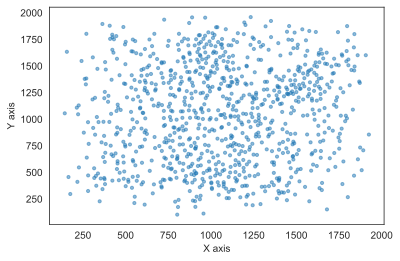

In [85]:
plt.scatter(coords.X, coords.Y, alpha = 0.5, s = 10)
plt.xlabel('X axis')
plt.ylabel('Y axis')